<a href="https://colab.research.google.com/github/gregoryfdel/DSPS_GFoote/blob/main/HW3/KS_earthquakes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Kolmogorov–Smirnov Test and Earthquakes

Initally Created by FedericaBBianco @fedhere for DSPS/MLNPS

Heavily rewritten and completed by Gregory Foote @gregoryfdel

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import re

import os

# Check if using google colab https://stackoverflow.com/questions/53581278/test-if-notebook-is-running-on-google-colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Default print is boring, lets use LaTeX
from IPython.display import Latex
from IPython.display import display

def LatexPrint(in_string):
    """
    Formats Strings using LaTeX

    :param string: Input Python String
    :return display: Output Display Object 
    """

    in_string = f"\\textnormal{{{in_string}}}" if IN_COLAB else in_string
    return(display(Latex(in_string)))


%matplotlib inline

### Run if not in google colab

In [1]:
%load_ext pycodestyle_magic
%pycodestyle_on

This homework asks you to reproduce the work in [Corral 2018](https://arxiv.org/pdf/0910.0055.pdf) which is well described, but not "reproducible". 
Corral 2018 uses a K-S test to show that at different magnitude scales the time gaps between earthquakes follows the same distribution. If true, this indicates that there is a consistent scaling law. 

The argument is a little convoluted, but it is a somewhat innovative use of the test. Corall compares the time gap between earthquakes  greater than a certain magnitude threshold with the time gaps between earthquakes above a different threshold, and finds no differences.

Remind yourself exactly what the K-S test is about :

    1 What is the test's Null Hypothsis that the K-S test tests?
    
    


The K-S test's null hypothesis is that a pair of samples are drawn from the same distribution




    2 What is the "statistic" or "pivotal quantity" that the test uses?
    


The test statistic for the K-S test is the maximum difference between the two normalized cumulative sample distributions.


    3 What does the probability distribution of this statistic depend on? 
    
   


The probability distribution of this statistic is only dependent on the amount of data in the two samples.
    

# Data Retrival

The first reason why the paper is not techincally _reproducible_ is that, while a link is provided to retrieve the data, the link is dead. This happens often. Services like [Zenodo](https://zenodo.org/) or journals that serve data provide some insurance against this but unfortunately the standards are not strict. 

We can retrieve the earthquake data from [this website](http://service.scedc.caltech.edu/eq-catalogs/poly.php) by making the appropiate POST request, by utilizing the `requests` library in python. By using python to directly query the server, as opposed to using the webform, I can ensure that anyone who looks at my code will be able to download the exact same dataset. Another reason is that others can scrutinize the input data to check for any mistakes I might of made. Because the authors did not comply with reproducibility standards I can only guess to the reigon they chose and ensure the number of entries in is similar to that of the authors.

### Redownloading the data

In order to download the data, we can make a POST request to the server with a payload containing all request data. To accomplish this in python, we first need the requests library; then we will stream the data output into a file.

In [11]:
%%capture
!pip install requests

In [2]:
import requests

request_data = {
	"outputfmt": "scec",
	"start_year": "1984",
	"start_month": "01",
	"start_day": "01",
	"start_hr": "00",
	"start_min": "00",
	"start_sec": "00",
	"end_year": "2002",
	"end_month": "12",
	"end_day": "31",
	"end_hr": "00",
	"end_min": "00",
	"end_sec": "00",
	"min_mag": "2.0",
	"max_mag": "9.0",
	"min_depth": "-5.0",
	"max_depth": "30.0",
	"latd1": "32.0",
	"lond1": "-122.0",
	"latd2": "37.0",
	"lond2": "-122.0",
	"latd3": "37.0",
	"lond3": "-114.0",
	"latd4": "32.0",
	"lond4": "-114.0",
	"polygoncoords": "32.72329178103315,-114.70275878906251;32.72329178103315,-114.70275878906251;35.02234920950592,-114.62036132812501;35.02234920950592,-114.62036132812501;39.01320836803336,-120.0146484375;39.01320836803336,-120.0146484375;36.512285105024866,-123.85986328125001;36.512285105024866,-123.85986328125001;32.57598036624046,-119.42138671875;32.57598036624046,-119.42138671875;32.751708525196584,-114.69726562500001;",
	"etype": "eq",
	"gtype": "l",
	"file_out": "Y"
}


if not os.path.exists("earthquakes_GregoryFoote.txt"):
	session = requests.session()
	
	response = requests.post('http://service.scedc.caltech.edu/cgi-bin/catalog/catalog_search.pl', data=request_data, stream=True)

	with open("earthquakes_GregoryFoote.txt", "w") as handle:
		for block in response.iter_lines(1024):
			handle.write(block.decode("ascii") + "\n")

### Visualize the selection

To visualize the selection reigon I chose, we will need three libraries:
* The `geopandas` library which uses `pandas` as a backend, to manipulate and store the data
* The `shapely` library, to create the polygon
* The `contextily` library, which will allow me easily add tile maps from the internet to the data

In [33]:
%%capture
!pip install geopandas
!pip install shapely
!pip install contextily

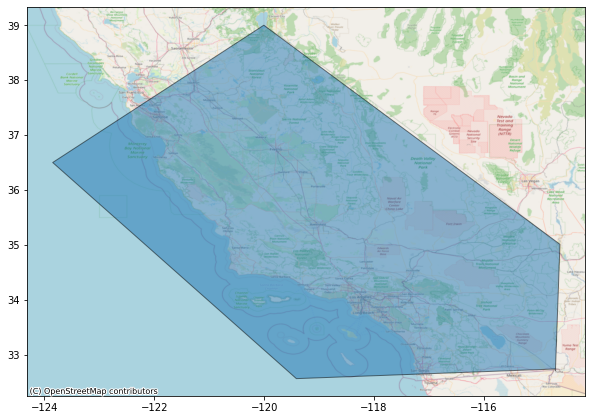

In [3]:
import geopandas
from shapely.geometry import Polygon
import contextily as ctx

parsed_polygon = Polygon([tuple(map(float, x.split(',')))[::-1] for x in request_data['polygoncoords'].split(";") if len(x) > 0])

# EPSG:3857 is used by MapBox which powers the website https://docs.mapbox.com/help/glossary/projection/
geodf = geopandas.GeoDataFrame(geometry=[parsed_polygon], crs='EPSG:3857')
ax = geodf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

# EPSG:4326 is used by GPS, so provides decent mapping projection over the entire planet https://epsg.io/4326
ctx.add_basemap(ax, zoom=8, crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)

#### Figure 1: A map highlighting the selection reigon

## Read in Data
Now that the data is downloaded, let's analyze it with pandas.

In [5]:
earthquake_data = pd.read_csv(
    "earthquakes_GregoryFoote.txt",
    parse_dates=[[0,1]], infer_datetime_format=True, keep_date_col=True,
    delim_whitespace=True, on_bad_lines='skip', skipinitialspace=True, skip_blank_lines=True,
    skiprows=2, skipfooter=2, engine='python')

LatexPrint(f"The size of my data table is: {' x '.join(map(str, earthquake_data.shape))}; this compares to the professors data which is 70798 x 34")

<IPython.core.display.Latex object>

Let's examine the data frame created from the file

In [6]:
earthquake_data.head()

,#YYY/MM/DD_HH:mm:SS.ss,#YYY/MM/DD,HH:mm:SS.ss,ET,GT,MAG,M,LAT,LON,DEPTH,Q,EVID,NPH,NGRM
0,1984/01/01 01:30:57.52,1984/01/01,01:30:57.52,eq,l,2.02,c,33.246,-116.433,1.6,C,28255,13,17
1,1984/01/01 05:31:34.16,1984/01/01,05:31:34.16,eq,l,2.12,c,32.945,-116.295,5.4,C,28259,18,42
2,1984/01/01 06:59:05.14,1984/01/01,06:59:05.14,eq,l,2.43,c,33.343,-117.628,5.6,C,28260,13,30
3,1984/01/01 11:10:25.29,1984/01/01,11:10:25.29,eq,l,2.07,c,33.668,-116.780,13.8,C,28270,19,40
4,1984/01/01 13:50:47.62,1984/01/01,13:50:47.62,eq,l,2.25,c,35.944,-118.322,-1.4,C,28546,29,56


### Let's make the data frame a bit more human friendly

In [7]:
trimmed_earthquake_data = earthquake_data.rename(columns={"#YYY/MM/DD_HH:mm:SS.ss":"datetime", "#YYY/MM/DD":"date", "HH:mm:SS.ss":"time", "MAG":"mag"})[["datetime", "date", "time", "mag"]]
trimmed_earthquake_data.head()

,datetime,date,time,mag
0,1984/01/01 01:30:57.52,1984/01/01,01:30:57.52,2.02
1,1984/01/01 05:31:34.16,1984/01/01,05:31:34.16,2.12
2,1984/01/01 06:59:05.14,1984/01/01,06:59:05.14,2.43
3,1984/01/01 11:10:25.29,1984/01/01,11:10:25.29,2.07
4,1984/01/01 13:50:47.62,1984/01/01,13:50:47.62,2.25


Right now the _time_, _date_, and _datetime_ columns right now are type 'O' which means object, typically a string. We want to convert these columns to datetime objects.

To do this conversion we will use the [astype](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.astype.html?highlight=astype#pandas.Series.astype) function to convert all three columns at once. Before this though, we need to replace any timestamp with greater than 60 seconds with 59 seconds; which we do with a combination of the [map](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.map.html?highlight=map#pandas.Series.map) and [re.sub](https://docs.python.org/3/library/re.html#re.sub) functions.

In [8]:
for fix_col in ['datetime', 'time']:
    trimmed_earthquake_data[fix_col] = trimmed_earthquake_data[fix_col].map(lambda x: re.sub("60.\d+", "59.00", x))

trimmed_earthquake_data = trimmed_earthquake_data.astype({"datetime":"datetime64", "date":"datetime64", "time":"datetime64"})

## Select valuable data

Following the description in Section 2  of Corral 2018 I removed all data that did not belong to a "stationary" period. Third paragraph section 2 of Corral 2018.

In [16]:
goodtimes = [[1984,1986.5],[1990.3, 1992.1],[1994.6, 1995.6],[1996.1, 1996.5], [1997, 1997.6], [1997.75, 1998.15], [1998.25, 1999.35], [2000.55, 2000.8], [2000.9, 2001.25], [2001.6, 2002], [2002.5, 2003]]
trimmed_earthquake_data['year_frac'] = trimmed_earthquake_data['datetime'].map(lambda x: float(x.year) + float((x - datetime.combine(datetime(x.year, datetime.min.month, datetime.min.day), datetime.min.time())).days/365.25))
good_rows = trimmed_earthquake_data.apply(lambda y: any([x[0] <= y['year_frac'] <= x[1] for x in goodtimes]), axis=1)
stationary_data = trimmed_earthquake_data[good_rows]

LatexPrint(f"There are {len(goodtimes)} timestamp pairs which are the boundaries of good data periods")
LatexPrint(f"There are {len(stationary_data)} earthquakes falling in the selected stationary periods")
stationary_data.head()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

,datetime,date,time,mag,year_frac
0,1984-01-01 01:30:57.520,1984-01-01,2021-09-21 01:30:57.520,2.02,1984.0
1,1984-01-01 05:31:34.160,1984-01-01,2021-09-21 05:31:34.160,2.12,1984.0
2,1984-01-01 06:59:05.140,1984-01-01,2021-09-21 06:59:05.140,2.43,1984.0
3,1984-01-01 11:10:25.290,1984-01-01,2021-09-21 11:10:25.290,2.07,1984.0
4,1984-01-01 13:50:47.620,1984-01-01,2021-09-21 13:50:47.620,2.25,1984.0


Now what you really want is the _time interval between earthquakes_ for all events greater than some magnitude m, while all you have are the date and time of the events.

In [17]:
stationary_data = stationary_data[stationary_data['mag'] > 1.99]
LatexPrint(f"There are {len(stationary_data)} earthquakes falling in the selected stationary periods with Magintude 2 and above, this is the same as before because this was selected for in the POST request")
stationary_data['gaps'] = stationary_data['datetime'].diff()
LatexPrint("Sample of the Table")
display(stationary_data.head())
LatexPrint("Summary of the Numerical Columns in the Table")
display(stationary_data.describe())

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

,datetime,date,time,mag,year_frac,gaps
0,1984-01-01 01:30:57.520,1984-01-01,2021-09-21 01:30:57.520,2.02,1984.0,NaT
1,1984-01-01 05:31:34.160,1984-01-01,2021-09-21 05:31:34.160,2.12,1984.0,0 days 04:00:36.640000
2,1984-01-01 06:59:05.140,1984-01-01,2021-09-21 06:59:05.140,2.43,1984.0,0 days 01:27:30.980000
3,1984-01-01 11:10:25.290,1984-01-01,2021-09-21 11:10:25.290,2.07,1984.0,0 days 04:11:20.150000
4,1984-01-01 13:50:47.620,1984-01-01,2021-09-21 13:50:47.620,2.25,1984.0,0 days 02:40:22.330000


<IPython.core.display.Latex object>

,mag,year_frac,gaps
count,15136.000000,15136.000000,15135
mean,2.365983,1992.873166,0 days 11:00:11.686307895
std,0.376059,6.162777,14 days 06:17:07.047178158
min,2.000000,1984.000000,0 days 00:00:00.170000
25%,2.100000,1985.837782,0 days 00:54:06.860000
50%,2.250000,1994.684463,0 days 03:05:24.600000
75%,2.510000,1998.331280,0 days 07:21:00.825000
max,5.800000,2002.993840,1388 days 11:06:10.750000


The first entry is NaT is Not a Time, which will interfere with further analysis, so I will remove it

In [18]:
final_data = stationary_data[1:]
final_data.head()

,datetime,date,time,mag,year_frac,gaps
1,1984-01-01 05:31:34.160,1984-01-01,2021-09-21 05:31:34.160,2.12,1984.0,0 days 04:00:36.640000
2,1984-01-01 06:59:05.140,1984-01-01,2021-09-21 06:59:05.140,2.43,1984.0,0 days 01:27:30.980000
3,1984-01-01 11:10:25.290,1984-01-01,2021-09-21 11:10:25.290,2.07,1984.0,0 days 04:11:20.150000
4,1984-01-01 13:50:47.620,1984-01-01,2021-09-21 13:50:47.620,2.25,1984.0,0 days 02:40:22.330000
5,1984-01-01 19:38:19.790,1984-01-01,2021-09-21 19:38:19.790,2.13,1984.0,0 days 05:47:32.170000


# data exploration
At this point you should wonder if this is the final dataset that you want to use and if anything is weird or suspicious about it. Visualize the distribution. A good way to visualize distributions is a histogram which you can prodice with pl.hist() or as a method of your dataframe series as ```df[SeriesName].plot(kind="hist")```. Produce a plot like the one below (label the axis! and describe it with a caption!). To get the logarithmic y axis you can se ```logy=True```, for example. in your ```df[SeriesName].plot``` call.

Text(0.5, 0, 'Time between earthquakes [seconds]')

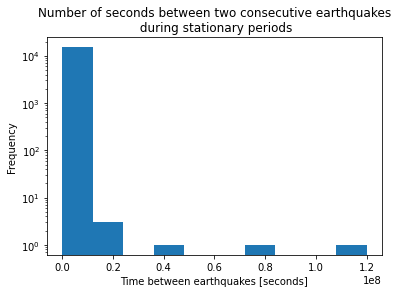

In [27]:
ax = final_data['gaps'].map(lambda x: x.total_seconds()).plot(kind="hist", logy=True, title="Number of seconds between two consecutive earthquakes\n during stationary periods", ylabel="Number")
ax.set_xlabel('Time between earthquakes [seconds]')

By limiting our data to the stationary periods, we have introduced an artifical effect from the earthquakes on the boundaries. We could redo our analysis and trim for the stationary periods at the end, but that would be a lot of additional work. We are instead going to remove any gap that is longer than a month, as that will not happen in natural circumstances as long as the mantle is hot.

Text(0.5, 0, 'Time between earthquakes [seconds]')

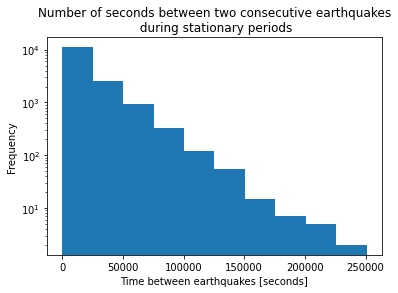

In [28]:
gap_sec = final_data['gaps'].map(lambda x: x.total_seconds())

ax = gap_sec[gap_sec < 2592000].plot(kind="hist", logy=True, title="Number of seconds between two consecutive earthquakes\n during stationary periods", ylabel="Number")
ax.set_xlabel('Time between earthquakes [seconds]')

## Data Analysis

To begin our data analysis, we first choose a p-value of 3-$\sigma$ as the threshold for rejecting the null hypothesis

Follow the instructions (algorithm) in **Section 3 paragraph 3** and compare your results with the results in table 1 with a threshold  of = 0.01 and 0.001

Do it for all 5 magnitude thresholds as indicated in the paper (and in Table 1).

Note that the x axis in plot Fig 1 is in _log space_. Use ```np.log10()``` to take the logarithm of the time gaps.

The pseudocode for the algorithm is [here](https://github.com/fedhere/DSPS/blob/master/HW3/Corral2018_pseudocode.md).


Reproduce the paper Fig 1 and Table 1. In the Table report the size of each dataset after cleaning the value of the statistic and the p-value, as done in Corral 2018. Use the scipy function for the 2 sample KS test. (resources [here](https://colab.research.google.com/notebooks/markdown_guide.ipynb#scrollTo=70pYkR9LiOV0) to learn about the table syntax in markdown)

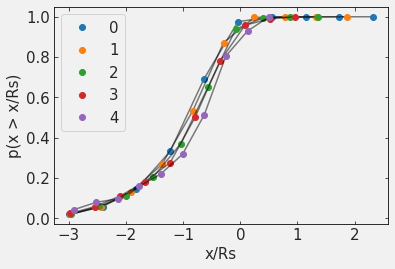

In [ ]:
# your code here

your table here

Did you find any statistical significant differences between the distributions? What does it mean? Is your result identical to Correll's 2018? Why or why not? **Discuss!**

### "extra credits"

**How could you _force_ a significant result?**
Organize your result for different magnitude threshold in a numpy array (it should be a 5x5 array) for both cutoffs (0.01 and 0.001). Each of these arrays should contain the p-value for the pair of distributions i,j in cell \[i\]\[j\] and \[j\]\[i\]. Use ```imshow``` to visualize this 2D data. FIrst visualize the matrix itself as done below.

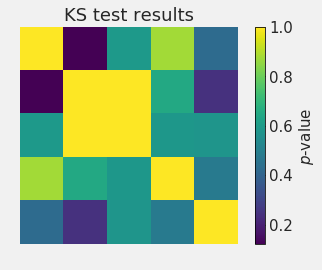

In [ ]:
# your code here
        
pl.imshow((ks_001));
pl.axis('off')
cb = pl.colorbar()
cb.ax.set_ylabel(r'$p$-value')
pl.title("KS test results");
#add a caption


Now visualize the result as a matrix where the cells are white if the results is not statistically significant and red otherwise. 
After doing it fot the set alpha threshold, lower your alpha threshold so that at least one pair of distribution has a statistically significant difference. **Warning!! this is an _unethical and horrifying practice_! Once you chose your significance threshold you are never allowed to change it! Why? Discuss**

Redoing it for threshold 0001